In [ ]:
!pip install rdflib
!pip install sentence_transformers

  Using cached rdflib-7.4.0-py3-none-any.whl.metadata (12 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 569.0/569.0 kB 9.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
from rdflib import Graph, URIRef, RDFS, RDF, OWL, Literal
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict


# ------------------------------
#  Ontology representation
# ------------------------------

class SemanticOntology:
    """
    Minimal ontology representation for semantic + triple similarity:
    - loads RDF/OWL/TTL file
    - extracts labels and comments (prefer label; fallback to local name)
    - works ONLY with local names (no full URIs)
    - collects schema-level triples (subClassOf, type, domain, range, disjointWith)
    - builds embeddings for all entities appearing in schema triples
    """

    SCHEMA_PREDICATES = {
        RDFS.subClassOf,
        RDF.type,
        RDFS.domain,
        RDFS.range,
        OWL.disjointWith,
    }

    CLASS_TYPES = {RDFS.Class, OWL.Class}
    PROP_TYPES = {RDF.Property, OWL.ObjectProperty,
                  OWL.DatatypeProperty, OWL.AnnotationProperty}

    def __init__(self, file_path, name="Ontology"):
        self.path = file_path
        self.name = name
        self.graph = Graph()

        # Entities keyed by LOCAL NAME only
        # local_name -> {local_name, label, comment, text, embedding}
        self.entities = {}

        # List of schema-level triples (local names)
        # Each triple: (s_local, p_local, o_local)
        self.schema_triples = []

        self.load()
        self.extract_entities_and_triples()

    # ---- Loading ----

    def load(self):
        """Load RDF/OWL file (auto-detect format, fallback to turtle)."""
        try:
            self.graph.parse(self.path)
        except Exception:
            self.graph.parse(self.path, format="ttl")

    # ---- Helpers ----

    @staticmethod
    def _local_name(uri_like):
        """Extract local name from URIRef or str (after # or last / or :)."""
        if isinstance(uri_like, URIRef):
            uri_like = str(uri_like)
        if "#" in uri_like:
            return uri_like.split("#")[-1]
        if "/" in uri_like:
            return uri_like.split("/")[-1]
        if ":" in uri_like:
            return uri_like.split(":")[-1]
        return uri_like

    # ---- Extraction ----

    def extract_entities_and_triples(self):
        """
        1) Extract labels/comments → entities (keyed by local name)
        2) Ensure all schema-triple participants are entities
        3) Extract schema-level triples in local-name form
        """
        labels = {}
        comments = {}

        # 1) Collect labels and comments keyed by local name
        for s, o in self.graph.subject_objects(RDFS.label):
            if isinstance(o, Literal) and (o.language in (None, "en")):
                ln = self._local_name(s)
                labels[ln] = str(o)

        for s, o in self.graph.subject_objects(RDFS.comment):
            if isinstance(o, Literal) and (o.language in (None, "en")):
                ln = self._local_name(s)
                comments[ln] = str(o)

        # Initial entities set: any local name with label or comment
        all_local_names = set(labels.keys()) | set(comments.keys())

        # 2) Ensure all schema participants become entities
        for s, p, o in self.graph:
            if p in self.SCHEMA_PREDICATES:
                if isinstance(s, URIRef):
                    all_local_names.add(self._local_name(s))
                if isinstance(p, URIRef):
                    all_local_names.add(self._local_name(p))
                if isinstance(o, URIRef):
                    all_local_names.add(self._local_name(o))

        # Build entity table
        for ln in all_local_names:
            label = labels.get(ln, "")
            comment = comments.get(ln, "")
            if label:
                text = (label + " " + comment).strip()
            else:
                # Fallback to local name if NO label
                text = (ln + " " + comment).strip() if comment else ln

            self.entities[ln] = {
                "local_name": ln,
                "label": label,
                "comment": comment,
                "text": text,
                "embedding": None,
            }

        # 3) Extract schema triples in local-name form
        self.schema_triples = self._extract_schema_triples()

    def _extract_schema_triples(self):
        triples = []

        # rdfs:subClassOf
        for s, o in self.graph.subject_objects(RDFS.subClassOf):
            if isinstance(s, URIRef) and isinstance(o, URIRef):
                triples.append(
                    (self._local_name(s),
                     self._local_name(RDFS.subClassOf),
                     self._local_name(o))
                )

        # rdf:type  (only if object is a class or property)
        for s, o in self.graph.subject_objects(RDF.type):
            if isinstance(s, URIRef) and o in (self.CLASS_TYPES | self.PROP_TYPES):
                triples.append(
                    (self._local_name(s),
                     self._local_name(RDF.type),
                     self._local_name(o))
                )

        # rdfs:domain
        for s, o in self.graph.subject_objects(RDFS.domain):
            if isinstance(s, URIRef) and isinstance(o, URIRef):
                triples.append(
                    (self._local_name(s),
                     self._local_name(RDFS.domain),
                     self._local_name(o))
                )

        # rdfs:range
        for s, o in self.graph.subject_objects(RDFS.range):
            if isinstance(s, URIRef) and isinstance(o, URIRef):
                triples.append(
                    (self._local_name(s),
                     self._local_name(RDFS.range),
                     self._local_name(o))
                )

        # owl:disjointWith
        for s, o in self.graph.subject_objects(OWL.disjointWith):
            if isinstance(s, URIRef) and isinstance(o, URIRef):
                triples.append(
                    (self._local_name(s),
                     self._local_name(OWL.disjointWith),
                     self._local_name(o))
                )

        return triples

    # ---- Embeddings ----

    def embed(self, model: SentenceTransformer):
        """Compute embeddings for all entities (texts) using MiniLM."""
        local_names = list(self.entities.keys())
        texts = [self.entities[ln]["text"] for ln in local_names]
        embs = model.encode(texts, show_progress_bar=False)

        for ln, emb in zip(local_names, embs):
            self.entities[ln]["embedding"] = emb


# ------------------------------
#  Comparator
# ------------------------------

import numpy as np
from rdflib import Graph, URIRef, RDFS, RDF, OWL, Literal
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict


# ------------------------------
#  Ontology representation
# ------------------------------

class SemanticOntology:
    """
    Ontology representation with improved embedding logic:
    - Entities embedded as "label [SEP] comment"
    - Schema triples embedded as "subject [SEP] predicate [SEP] object"
    """

    SCHEMA_PREDICATES = {
        RDFS.subClassOf,
        RDF.type,
        RDFS.domain,
        RDFS.range,
        OWL.disjointWith,
    }

    CLASS_TYPES = {RDFS.Class, OWL.Class}
    PROP_TYPES = {RDF.Property, OWL.ObjectProperty,
                  OWL.DatatypeProperty, OWL.AnnotationProperty}

    def __init__(self, file_path, name="Ontology"):
        self.path = file_path
        self.name = name
        self.graph = Graph()

        # Local name → entity data
        self.entities = {}

        # Schema triples in local-name form
        self.schema_triples = []

        # Triple embeddings
        self.triple_embeddings = {}

        self.load()
        self.extract_entities_and_triples()

    # ---- Loading ----

    def load(self):
        try:
            self.graph.parse(self.path)
        except Exception:
            self.graph.parse(self.path, format="ttl")

    # ---- Helpers ----

    @staticmethod
    def _local_name(uri_like):
        if isinstance(uri_like, URIRef):
            uri_like = str(uri_like)
        if "#" in uri_like:
            return uri_like.split("#")[-1]
        if "/" in uri_like:
            return uri_like.split("/")[-1]
        if ":" in uri_like:
            return uri_like.split(":")[-1]
        return uri_like

    # ---- Extraction ----

    def extract_entities_and_triples(self):
        labels = {}
        comments = {}

        # Collect labels
        for s, o in self.graph.subject_objects(RDFS.label):
            if isinstance(o, Literal) and (o.language in (None, "en")):
                labels[self._local_name(s)] = str(o)

        # Collect comments
        for s, o in self.graph.subject_objects(RDFS.comment):
            if isinstance(o, Literal) and (o.language in (None, "en")):
                comments[self._local_name(s)] = str(o)

        all_local_names = set(labels.keys()) | set(comments.keys())

        # Ensure schema participants included
        for s, p, o in self.graph:
            if p in self.SCHEMA_PREDICATES:
                if isinstance(s, URIRef):
                    all_local_names.add(self._local_name(s))
                if isinstance(p, URIRef):
                    all_local_names.add(self._local_name(p))
                if isinstance(o, URIRef):
                    all_local_names.add(self._local_name(o))

        # Build entity entries with NEW FORMAT: "label [SEP] comment"
        for ln in all_local_names:
            label = labels.get(ln, "")
            comment = comments.get(ln, "")

            if label and comment:
                text = f"{label} [SEP] {comment}"
            elif label:
                text = label
            elif comment:
                text = f"{ln} [SEP] {comment}"
            else:
                text = ln

            self.entities[ln] = {
                "local_name": ln,
                "label": label,
                "comment": comment,
                "text": text,
                "embedding": None,
            }

        # Extract triples
        self.schema_triples = self._extract_schema_triples()

    def _extract_schema_triples(self):
        triples = []

        for s, o in self.graph.subject_objects(RDFS.subClassOf):
            if isinstance(s, URIRef) and isinstance(o, URIRef):
                triples.append((self._local_name(s),
                                self._local_name(RDFS.subClassOf),
                                self._local_name(o)))

        for s, o in self.graph.subject_objects(RDF.type):
            if isinstance(s, URIRef) and o in (self.CLASS_TYPES | self.PROP_TYPES):
                triples.append((self._local_name(s),
                                self._local_name(RDF.type),
                                self._local_name(o)))

        for s, o in self.graph.subject_objects(RDFS.domain):
            if isinstance(s, URIRef) and isinstance(o, URIRef):
                triples.append((self._local_name(s),
                                self._local_name(RDFS.domain),
                                self._local_name(o)))

        for s, o in self.graph.subject_objects(RDFS.range):
            if isinstance(s, URIRef) and isinstance(o, URIRef):
                triples.append((self._local_name(s),
                                self._local_name(RDFS.range),
                                self._local_name(o)))

        for s, o in self.graph.subject_objects(OWL.disjointWith):
            if isinstance(s, URIRef) and isinstance(o, URIRef):
                triples.append((self._local_name(s),
                                self._local_name(OWL.disjointWith),
                                self._local_name(o)))

        return triples

    # ---- Embeddings ----

    def embed(self, model: SentenceTransformer):
        """Embed entities and schema triples using the improved textual forms."""

        # ---- Entity embeddings ----
        local_names = list(self.entities.keys())
        texts = [self.entities[ln]["text"] for ln in local_names]

        embs = model.encode(texts, show_progress_bar=False)

        for ln, emb in zip(local_names, embs):
            self.entities[ln]["embedding"] = emb

        # ---- Triple embeddings ----
        triple_texts = []
        triple_keys = []

        for (s, p, o) in self.schema_triples:
            s_text = self.entities[s]["text"]
            p_text = self.entities[p]["text"]
            o_text = self.entities[o]["text"]

            triple_text = f"{s_text} [SEP] {p_text} [SEP] {o_text}"
            triple_keys.append((s, p, o))
            triple_texts.append(triple_text)

        triple_embs = model.encode(triple_texts, show_progress_bar=False)

        self.triple_embeddings = {
            key: emb for key, emb in zip(triple_keys, triple_embs)
        }


# ------------------------------
#  Comparator
# ------------------------------

class SemanticComparator:
    """
    Upgraded comparator:
    - Entity similarity uses new "label [SEP] comment" embeddings
    - Triple similarity uses ENTIRE TRIPLE EMBEDDING
      (cosine between triple text embeddings)
    """

    def __init__(self, gold: SemanticOntology, llm: SemanticOntology):
        self.gold = gold
        self.llm = llm
        self.model = SentenceTransformer("all-MiniLM-L6-v2")

        self.entity_match_table = None
        self.entity_bins = None
        self.triple_match_table = None
        self.triple_bins = None

    @staticmethod
    def _bucket(sim):
        if sim < 0.50:
            return "<50"
        elif sim < 0.60:
            return "50-60"
        elif sim < 0.70:
            return "60-70"
        elif sim < 0.80:
            return "70-80"
        elif sim < 0.90:
            return "80-90"
        else:
            return "90-100"

    @staticmethod
    def _cosine(emb1, emb2):
        if emb1 is None or emb2 is None:
            return 0.0
        return float(cosine_similarity([emb1], [emb2])[0][0])

    def prepare(self):
        self.gold.embed(self.model)
        self.llm.embed(self.model)

    # ------------------------------
    #  Entity-level comparison
    # ------------------------------

    def compare_entities(self):
        gold_lns = list(self.gold.entities.keys())
        llm_lns = list(self.llm.entities.keys())

        gold_embs = np.stack([self.gold.entities[ln]["embedding"]
                              for ln in gold_lns])
        llm_embs = np.stack([self.llm.entities[ln]["embedding"]
                             for ln in llm_lns])

        sim_matrix = cosine_similarity(llm_embs, gold_embs)

        match_rows = []
        bin_counts = defaultdict(int)

        for i, llm_ln in enumerate(llm_lns):
            sims = sim_matrix[i]
            j_best = int(np.argmax(sims))
            best_sim = float(sims[j_best])
            gold_ln = gold_lns[j_best]

            bucket = self._bucket(best_sim)
            bin_counts[bucket] += 1

            match_rows.append({
                "llm_local": llm_ln,
                "llm_text": self.llm.entities[llm_ln]["text"],
                "gold_local": gold_ln,
                "gold_text": self.gold.entities[gold_ln]["text"],
                "similarity": best_sim,
                "bucket": bucket,
            })

        total = len(llm_lns)
        all_buckets = ["<50", "50-60", "60-70", "70-80", "80-90", "90-100"]

        bin_stats = []
        for b in all_buckets:
            count = bin_counts.get(b, 0)
            perc = 100.0 * count / total if total > 0 else 0.0
            bin_stats.append({"bucket": b,
                              "count": count,
                              "percent_llm_entities": perc})

        self.entity_match_table = sorted(
            match_rows, key=lambda r: r["similarity"], reverse=True)
        self.entity_bins = bin_stats

    # ------------------------------
    #  Triple-level comparison (new)
    # ------------------------------

    def compare_triples(self):
        gold_triples = self.gold.schema_triples
        llm_triples = self.llm.schema_triples

        gold_embs = self.gold.triple_embeddings
        llm_embs = self.llm.triple_embeddings

        match_rows = []
        bin_counts = defaultdict(int)

        for triple in llm_triples:
            llm_emb = llm_embs.get(triple, None)

            best_sim = 0.0
            best_gold = None

            if llm_emb is not None:
                for gtr, gemb in gold_embs.items():
                    sim = self._cosine(llm_emb, gemb)
                    if sim > best_sim:
                        best_sim = sim
                        best_gold = gtr

            bucket = self._bucket(best_sim)
            bin_counts[bucket] += 1

            match_rows.append({
                "llm_triple": triple,
                "gold_triple": best_gold,
                "similarity": best_sim,
                "bucket": bucket,
            })

        total = len(llm_triples)
        all_buckets = ["<50", "50-60", "60-70", "70-80", "80-90", "90-100"]

        bin_stats = []
        for b in all_buckets:
            count = bin_counts.get(b, 0)
            perc = 100.0 * count / total if total > 0 else 0.0
            bin_stats.append({"bucket": b,
                              "count": count,
                              "percent_llm_triples": perc})

        self.triple_match_table = sorted(
            match_rows, key=lambda r: r["similarity"], reverse=True)
        self.triple_bins = bin_stats


    # ------------------------------
    #  Convenience printing
    # ------------------------------

    def print_entity_summary(self, top_k=20):
        print(f"\n=== Entity-level semantic alignment ({self.llm.name} vs {self.gold.name}) ===")
        print("Bucket stats (LLM entities):")
        for row in self.entity_bins:
            print(f"  {row['bucket']:>6}: {row['count']:4d} "
                  f"({row['percent_llm_entities']:.1f}%)")

        print(f"\nTop {top_k} most similar entity pairs:")
        for row in self.entity_match_table[:top_k]:
            print(f"  {row['llm_local']}  ↔  {row['gold_local']}  "
                  f"(sim={row['similarity']:.3f})")

    def print_triple_summary(self, top_k=20):
        print(f"\n=== Triple-level semantic alignment ({self.llm.name} vs {self.gold.name}) ===")
        print("Bucket stats (LLM schema triples):")
        for row in self.triple_bins:
            print(f"  {row['bucket']:>6}: {row['count']:4d} "
                  f"({row['percent_llm_triples']:.1f}%)")

        print(f"\nTop {top_k} most similar matching triples:")
        shown = 0
        for row in self.triple_match_table:
            # NEW condition (replaces matched_gold_triple)
            if row["gold_triple"] is None:
                continue
            if row["similarity"] <= 0:
                continue

            (s_l, p_l, o_l) = row["llm_triple"]
            (s_g, p_g, o_g) = row["gold_triple"]

            print(f"  LLM:  {s_l}  {p_l}  {o_l}")
            print(f"  GOLD: {s_g}  {p_g}  {o_g}")
            print(f"       triple_sim={row['similarity']:.3f}\n")

            shown += 1
            if shown >= top_k:
                break



# ------------------------------
#  Example usage (adjust paths)
# ------------------------------

if __name__ == "__main__":
    # Replace with your actual file paths
    gold_path = "/content/sewernet.owl"
    llm_path = "/content/sewernet_deepseek.ttl"

    gold = SemanticOntology(gold_path, name="SewerNet-Gold")
    llm = SemanticOntology(llm_path, name="SewerNet-DeepSeek")

    comp = SemanticComparator(gold, llm)
    comp.prepare()

    comp.compare_entities()
    comp.compare_triples()

    comp.print_entity_summary(top_k=20)
    comp.print_triple_summary(top_k=20)



=== Entity-level semantic alignment (SewerNet-DeepSeek vs SewerNet-Gold) ===
Bucket stats (LLM entities):
     <50:  258 (44.0%)
   50-60:  227 (38.7%)
   60-70:   61 (10.4%)
   70-80:   22 (3.7%)
   80-90:    7 (1.2%)
  90-100:   12 (2.0%)

Top 20 most similar entity pairs:
  disjointWith  ↔  disjointWith  (sim=1.000)
  physical-object  ↔  physical-object  (sim=1.000)
  date  ↔  date  (sim=1.000)
  type  ↔  type  (sim=1.000)
  Restriction  ↔  Restriction  (sim=1.000)
  range  ↔  range  (sim=1.000)
  SymmetricProperty  ↔  SymmetricProperty  (sim=1.000)
  subClassOf  ↔  subClassOf  (sim=1.000)
  domain  ↔  domain  (sim=1.000)
  quality  ↔  quality  (sim=1.000)
  Class  ↔  Class  (sim=1.000)
  ObjectProperty  ↔  ObjectProperty  (sim=1.000)
  PumpingStation  ↔  PumpingStation  (sim=0.895)
  TreatmentPlant  ↔  TreatmentPlant  (sim=0.873)
  hasMaterialType  ↔  Material  (sim=0.819)
  PumpingStationA  ↔  PumpingStation  (sim=0.818)
  Inlet  ↔  Inlet  (sim=0.815)
  DatatypeProperty  ↔  Datat

In [ ]:
if __name__ == "__main__":
    # Replace with your actual file paths
    gold_path = "/content/sewernet.owl"
    llm_path = "/content/sewernet_llama.ttl"

    gold = SemanticOntology(gold_path, name="SewerNet-Gold")
    llm = SemanticOntology(llm_path, name="SewerNet-Llama")

    comp = SemanticComparator(gold, llm)
    comp.prepare()

    comp.compare_entities()
    comp.compare_triples()

    comp.print_entity_summary(top_k=20)
    comp.print_triple_summary(top_k=20)


=== Entity-level semantic alignment (SewerNet-Llama vs SewerNet-Gold) ===
Bucket stats (LLM entities):
     <50:   85 (39.9%)
   50-60:   55 (25.8%)
   60-70:   33 (15.5%)
   70-80:   19 (8.9%)
   80-90:    5 (2.3%)
  90-100:   16 (7.5%)

Top 20 most similar entity pairs:
  NamedIndividual  ↔  NamedIndividual  (sim=1.000)
  AnnotationProperty  ↔  AnnotationProperty  (sim=1.000)
  Thing  ↔  Thing  (sim=1.000)
  type  ↔  type  (sim=1.000)
  date  ↔  date  (sim=1.000)
  Feature  ↔  feature  (sim=1.000)
  Restriction  ↔  Restriction  (sim=1.000)
  SymmetricProperty  ↔  SymmetricProperty  (sim=1.000)
  range  ↔  range  (sim=1.000)
  subClassOf  ↔  subClassOf  (sim=1.000)
  domain  ↔  domain  (sim=1.000)
  Class  ↔  Class  (sim=1.000)
  Ontology  ↔  Ontology  (sim=1.000)
  Quality  ↔  quality  (sim=1.000)
  ObjectProperty  ↔  ObjectProperty  (sim=1.000)
  PumpingStation  ↔  PumpingStation  (sim=0.932)
  Network  ↔  Network  (sim=0.852)
  Inlet  ↔  Inlet  (sim=0.828)
  SewerNetwork  ↔  Netwo

In [ ]:
if __name__ == "__main__":
    # Replace with your actual file paths
    gold_path = "/content/sewernet.owl"
    llm_path = "/content/sewerNetMistral.ttl"

    gold = SemanticOntology(gold_path, name="SewerNet-Gold")
    llm = SemanticOntology(llm_path, name="SewerNet-Mistral")

    comp = SemanticComparator(gold, llm)
    comp.prepare()

    comp.compare_entities()
    comp.compare_triples()

    comp.print_entity_summary(top_k=20)
    comp.print_triple_summary(top_k=20)


=== Entity-level semantic alignment (SewerNet-Mistral vs SewerNet-Gold) ===
Bucket stats (LLM entities):
     <50:  169 (46.7%)
   50-60:  116 (32.0%)
   60-70:   52 (14.4%)
   70-80:   11 (3.0%)
   80-90:    3 (0.8%)
  90-100:   11 (3.0%)

Top 20 most similar entity pairs:
  disjointWith  ↔  disjointWith  (sim=1.000)
  type  ↔  type  (sim=1.000)
  Restriction  ↔  Restriction  (sim=1.000)
  SymmetricProperty  ↔  SymmetricProperty  (sim=1.000)
  subClassOf  ↔  subClassOf  (sim=1.000)
  domain  ↔  domain  (sim=1.000)
  range  ↔  range  (sim=1.000)
  Thing  ↔  Thing  (sim=1.000)
  Class  ↔  Class  (sim=1.000)
  Ontology  ↔  Ontology  (sim=1.000)
  ObjectProperty  ↔  ObjectProperty  (sim=1.000)
  hasMaterial  ↔  Material  (sim=0.821)
  DatatypeProperty  ↔  Datatype  (sim=0.811)
  SewerNetwork  ↔  Network  (sim=0.809)
  WastewaterNetwork  ↔  WastewaterNetwork  (sim=0.764)
  NetworkComponent  ↔  Network  (sim=0.757)
  Inlet  ↔  Inlet  (sim=0.750)
  usesFoundationalOntology  ↔    (sim=0.737)

In [ ]:
if __name__ == "__main__":
    # Replace with your actual file paths
    gold_path = "/content/sewernet.owl"
    llm_path = "/content/SewerNet_gpt_4o.ttl"

    gold = SemanticOntology(gold_path, name="SewerNet-Gold")
    llm = SemanticOntology(llm_path, name="SewerNet-4o")

    comp = SemanticComparator(gold, llm)
    comp.prepare()

    comp.compare_entities()
    comp.compare_triples()

    comp.print_entity_summary(top_k=20)
    comp.print_triple_summary(top_k=20)


=== Entity-level semantic alignment (SewerNet-4o vs SewerNet-Gold) ===
Bucket stats (LLM entities):
     <50:  171 (65.3%)
   50-60:   47 (17.9%)
   60-70:   24 (9.2%)
   70-80:    9 (3.4%)
   80-90:    2 (0.8%)
  90-100:    9 (3.4%)

Top 20 most similar entity pairs:
  date  ↔  date  (sim=1.000)
  type  ↔  type  (sim=1.000)
  SymmetricProperty  ↔  SymmetricProperty  (sim=1.000)
  domain  ↔  domain  (sim=1.000)
  ObjectProperty  ↔  ObjectProperty  (sim=1.000)
  range  ↔  range  (sim=1.000)
  Ontology  ↔  Ontology  (sim=1.000)
  subClassOf  ↔  subClassOf  (sim=1.000)
  Class  ↔  Class  (sim=1.000)
  DatatypeProperty  ↔  Datatype  (sim=0.811)
  PumpingStation  ↔  PumpingStation  (sim=0.808)
  Pipe  ↔  StormwaterConduit  (sim=0.783)
  Conduit  ↔  Channel  (sim=0.754)
  SewerNetworkComponent  ↔  Network  (sim=0.749)
  sewerNet  ↔    (sim=0.740)
  Maintenance  ↔  Maintenance  (sim=0.728)
  RetentionBasin  ↔  RetentionBasin  (sim=0.715)
  FunctionalProperty  ↔  Functional  (sim=0.711)
  dur

In [ ]:
!pip install faiss-cpu sentence-transformers rdflib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.6/23.6 MB 80.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 569.0/569.0 kB 43.9 MB/s eta 0:00:00


In [ ]:
import json
from collections import defaultdict

import numpy as np
from rdflib import Graph, URIRef, RDFS, RDF, OWL, Literal
from sentence_transformers import SentenceTransformer
import torch

# Try FAISS (for fast nearest neighbor search)
try:
    import faiss  # pip install faiss-cpu
except ImportError:
    faiss = None
    print("WARNING: faiss is not installed. Install with `pip install faiss-cpu` for good performance.")


# ------------------------------
#  Ontology representation
# ------------------------------

class SemanticOntology:
    """
    Ontology representation with improved embedding logic:
    - Entities embedded as "label [SEP] comment" (or fallback to local name)
    - Schema triples embedded as "subject [SEP] predicate [SEP] object"
    - Supports saving/loading embeddings to avoid recomputation
    """

    SCHEMA_PREDICATES = {
        RDFS.subClassOf,
        RDF.type,
        RDFS.domain,
        RDFS.range,
        OWL.disjointWith,
    }

    CLASS_TYPES = {RDFS.Class, OWL.Class}
    PROP_TYPES = {
        RDF.Property,
        OWL.ObjectProperty,
        OWL.DatatypeProperty,
        OWL.AnnotationProperty,
    }

    def __init__(self, file_path, name="Ontology"):
        self.path = file_path
        self.name = name
        self.graph = Graph()

        # Local name → entity data
        # {
        #   local_name: {
        #       "local_name": ...,
        #       "label": ...,
        #       "comment": ...,
        #       "text": "label [SEP] comment",
        #       "embedding": np.ndarray or None
        #   }
        # }
        self.entities = {}

        # Schema triples in local-name form: list of (s, p, o)
        self.schema_triples = []

        # Triple embeddings: { (s,p,o): np.ndarray }
        self.triple_embeddings = {}

        self.load()
        self.extract_entities_and_triples()

    # ---- Loading ----

    def load(self):
        """Load RDF/OWL file (auto-detect format, fallback to turtle)."""
        try:
            self.graph.parse(self.path)
        except Exception:
            self.graph.parse(self.path, format="ttl")

    # ---- Helpers ----

    @staticmethod
    def _local_name(uri_like):
        """Extract local name from URIRef or str (after #, last /, or :)."""
        if isinstance(uri_like, URIRef):
            uri_like = str(uri_like)
        if "#" in uri_like:
            return uri_like.split("#")[-1]
        if "/" in uri_like:
            return uri_like.split("/")[-1]
        if ":" in uri_like:
            return uri_like.split(":")[-1]
        return uri_like

    # ---- Extraction ----

    def extract_entities_and_triples(self):
        """
        1) Extract labels/comments → entities (keyed by local name)
        2) Ensure all schema-triple participants are entities
        3) Extract schema-level triples in local-name form
        """
        labels = {}
        comments = {}

        # Collect labels
        for s, o in self.graph.subject_objects(RDFS.label):
            if isinstance(o, Literal) and (o.language in (None, "en")):
                labels[self._local_name(s)] = str(o)

        # Collect comments
        for s, o in self.graph.subject_objects(RDFS.comment):
            if isinstance(o, Literal) and (o.language in (None, "en")):
                comments[self._local_name(s)] = str(o)

        all_local_names = set(labels.keys()) | set(comments.keys())

        # Ensure all schema participants are included as entities (s, p, o)
        for s, p, o in self.graph:
            if p in self.SCHEMA_PREDICATES:
                if isinstance(s, URIRef):
                    all_local_names.add(self._local_name(s))
                if isinstance(p, URIRef):
                    all_local_names.add(self._local_name(p))
                if isinstance(o, URIRef):
                    all_local_names.add(self._local_name(o))

        # Build entity entries with format: "label [SEP] comment"
        for ln in all_local_names:
            label = labels.get(ln, "")
            comment = comments.get(ln, "")

            if label and comment:
                text = f"{label} [SEP] {comment}"
            elif label:
                text = label
            elif comment:
                text = f"{ln} [SEP] {comment}"
            else:
                text = ln

            self.entities[ln] = {
                "local_name": ln,
                "label": label,
                "comment": comment,
                "text": text,
                "embedding": None,
            }

        # Extract triples in local-name form
        self.schema_triples = self._extract_schema_triples()

    def _extract_schema_triples(self):
        triples = []

        # rdfs:subClassOf
        for s, o in self.graph.subject_objects(RDFS.subClassOf):
            if isinstance(s, URIRef) and isinstance(o, URIRef):
                triples.append(
                    (self._local_name(s),
                     self._local_name(RDFS.subClassOf),
                     self._local_name(o))
                )

        # rdf:type (subject must be URIRef, object must be class/property type)
        for s, o in self.graph.subject_objects(RDF.type):
            if isinstance(s, URIRef) and o in (self.CLASS_TYPES | self.PROP_TYPES):
                triples.append(
                    (self._local_name(s),
                     self._local_name(RDF.type),
                     self._local_name(o))
                )

        # rdfs:domain
        for s, o in self.graph.subject_objects(RDFS.domain):
            if isinstance(s, URIRef) and isinstance(o, URIRef):
                triples.append(
                    (self._local_name(s),
                     self._local_name(RDFS.domain),
                     self._local_name(o))
                )

        # rdfs:range
        for s, o in self.graph.subject_objects(RDFS.range):
            if isinstance(s, URIRef) and isinstance(o, URIRef):
                triples.append(
                    (self._local_name(s),
                     self._local_name(RDFS.range),
                     self._local_name(o))
                )

        # owl:disjointWith
        for s, o in self.graph.subject_objects(OWL.disjointWith):
            if isinstance(s, URIRef) and isinstance(o, URIRef):
                triples.append(
                    (self._local_name(s),
                     self._local_name(OWL.disjointWith),
                     self._local_name(o))
                )

        return triples

    # ---- Embeddings ----

    def embed(self, model: SentenceTransformer, batch_size: int = 128):
        """
        Embed entities and schema triples using the improved textual forms.
        Always recomputes; call conditionally from outside if you want to reuse
        loaded embeddings.
        """

        # ---- Entity embeddings ----
        local_names = list(self.entities.keys())
        if not local_names:
            print(f"[{self.name}] No entities to embed.")
            return

        texts = [self.entities[ln]["text"] for ln in local_names]
        print(f"[{self.name}] Encoding {len(texts)} entities...")
        embs = model.encode(
            texts,
            batch_size=batch_size,
            show_progress_bar=True,
            convert_to_numpy=True,
        ).astype("float32")

        for ln, emb in zip(local_names, embs):
            self.entities[ln]["embedding"] = emb

        # ---- Triple embeddings ----
        triple_texts = []
        triple_keys = []

        for (s, p, o) in self.schema_triples:
            s_text = self.entities.get(s, {"text": s})["text"]
            p_text = self.entities.get(p, {"text": p})["text"]
            o_text = self.entities.get(o, {"text": o})["text"]

            triple_text = f"{s_text} [SEP] {p_text} [SEP] {o_text}"
            triple_keys.append((s, p, o))
            triple_texts.append(triple_text)

        if triple_texts:
            print(f"[{self.name}] Encoding {len(triple_texts)} triples...")
            triple_embs = model.encode(
                triple_texts,
                batch_size=batch_size,
                show_progress_bar=True,
                convert_to_numpy=True,
            ).astype("float32")

            self.triple_embeddings = {
                key: emb for key, emb in zip(triple_keys, triple_embs)
            }
        else:
            self.triple_embeddings = {}

    # ---- Save / Load embeddings ----

    def save_embeddings(self, file_prefix: str):
        """
        Save entity and triple embeddings to disk:
        - {file_prefix}_entities.npz + {file_prefix}_entities.json
        - {file_prefix}_triples.npz + {file_prefix}_triples.json
        """
        # ---- Entities ----
        entity_names = list(self.entities.keys())
        if not entity_names:
            print(f"[{self.name}] No entities to save.")
        else:
            if any(self.entities[n]["embedding"] is None for n in entity_names):
                raise RuntimeError(
                    f"[{self.name}] Some entity embeddings are None. "
                    "Compute embeddings before saving."
                )

            entity_embs = np.stack(
                [self.entities[n]["embedding"] for n in entity_names]
            )

            np.savez(f"{file_prefix}_entities.npz", embeddings=entity_embs)
            with open(f"{file_prefix}_entities.json", "w", encoding="utf-8") as f:
                json.dump(
                    {
                        "names": entity_names,
                        "texts": {
                            n: self.entities[n]["text"] for n in entity_names
                        },
                    },
                    f,
                    ensure_ascii=False,
                    indent=2,
                )

        # ---- Triples ----
        triple_keys = list(self.triple_embeddings.keys())
        if not triple_keys:
            print(f"[{self.name}] No triple embeddings to save.")
        else:
            triple_embs = np.stack(
                [self.triple_embeddings[t] for t in triple_keys]
            )

            np.savez(f"{file_prefix}_triples.npz", embeddings=triple_embs)
            with open(f"{file_prefix}_triples.json", "w", encoding="utf-8") as f:
                # JSON can't store tuples, so store as lists
                json.dump(
                    {"triples": [list(t) for t in triple_keys]},
                    f,
                    ensure_ascii=False,
                    indent=2,
                )

        print(f"[{self.name}] Saved embeddings to '{file_prefix}_*'")

    def load_embeddings(self, file_prefix: str):
        """
        Load entity and triple embeddings from disk.
        Assumes the ontology structure matches what was used at save time.
        """
        # ---- Entities ----
        try:
            data = np.load(f"{file_prefix}_entities.npz")
            with open(f"{file_prefix}_entities.json", "r", encoding="utf-8") as f:
                meta = json.load(f)

            entity_names = meta["names"]
            texts = meta["texts"]
            embs = data["embeddings"]

            if len(entity_names) != len(embs):
                raise RuntimeError(
                    f"[{self.name}] Entity name count and embedding count mismatch."
                )

            for name, emb in zip(entity_names, embs):
                if name not in self.entities:
                    # If ontology changed but you still want to reuse embeddings,
                    # we create missing entries with minimal info.
                    self.entities[name] = {
                        "local_name": name,
                        "label": "",
                        "comment": "",
                        "text": texts.get(name, name),
                        "embedding": emb,
                    }
                else:
                    self.entities[name]["text"] = texts.get(
                        name, self.entities[name]["text"]
                    )
                    self.entities[name]["embedding"] = emb

            print(f"[{self.name}] Loaded {len(entity_names)} entity embeddings.")
        except FileNotFoundError:
            print(f"[{self.name}] No entity embedding files found for prefix '{file_prefix}'.")

        # ---- Triples ----
        try:
            data = np.load(f"{file_prefix}_triples.npz")
            with open(f"{file_prefix}_triples.json", "r", encoding="utf-8") as f:
                meta = json.load(f)

            triple_lists = meta["triples"]
            triple_keys = [tuple(t) for t in triple_lists]
            triple_embs = data["embeddings"]

            if len(triple_keys) != len(triple_embs):
                raise RuntimeError(
                    f"[{self.name}] Triple key count and embedding count mismatch."
                )

            self.triple_embeddings = {
                key: emb for key, emb in zip(triple_keys, triple_embs)
            }
            print(f"[{self.name}] Loaded {len(triple_keys)} triple embeddings.")
        except FileNotFoundError:
            print(f"[{self.name}] No triple embedding files found for prefix '{file_prefix}'.")
            self.triple_embeddings = {}


# ------------------------------
#  Comparator
# ------------------------------

class SemanticComparator:
    """
    Comparator:
    - Entity similarity using "label [SEP] comment" embeddings
    - Triple similarity using ENTIRE TRIPLE EMBEDDING
      (cosine ≈ inner product between normalized embeddings via FAISS)
    - Uses GPU for SentenceTransformer if available
    """

    def __init__(self, gold: SemanticOntology, llm: SemanticOntology):
        self.gold = gold
        self.llm = llm

        device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"Using device: {device}")
        self.model = SentenceTransformer("all-MiniLM-L6-v2", device=device)

        self.entity_match_table = None
        self.entity_bins = None
        self.triple_match_table = None
        self.triple_bins = None

    # ---- Utility ----

    @staticmethod
    def _bucket(sim):
        if sim < 0.50:
            return "<50"
        elif sim < 0.60:
            return "50-60"
        elif sim < 0.70:
            return "60-70"
        elif sim < 0.80:
            return "70-80"
        elif sim < 0.90:
            return "80-90"
        else:
            return "90-100"

    @staticmethod
    def _normalize_rows(mat: np.ndarray) -> np.ndarray:
        norms = np.linalg.norm(mat, axis=1, keepdims=True)
        norms[norms == 0.0] = 1.0
        return mat / norms

    def prepare(self, batch_size: int = 128):
        """
        Ensure both ontologies have embeddings.
        - If embeddings are already loaded (via load_embeddings), they are reused.
        - Otherwise, embeddings are computed.
        """
        # Gold
        need_gold_entities = any(
            v["embedding"] is None for v in self.gold.entities.values()
        )
        need_gold_triples = len(self.gold.triple_embeddings) == 0

        if need_gold_entities or need_gold_triples:
            print("[Comparator] Computing embeddings for GOLD ontology...")
            self.gold.embed(self.model, batch_size=batch_size)
        else:
            print("[Comparator] Reusing existing GOLD embeddings.")

        # LLM
        need_llm_entities = any(
            v["embedding"] is None for v in self.llm.entities.values()
        )
        need_llm_triples = len(self.llm.triple_embeddings) == 0

        if need_llm_entities or need_llm_triples:
            print("[Comparator] Computing embeddings for LLM ontology...")
            self.llm.embed(self.model, batch_size=batch_size)
        else:
            print("[Comparator] Reusing existing LLM embeddings.")

    # ------------------------------
    #  Entity-level comparison
    # ------------------------------

    def compare_entities(self):
        gold_lns = list(self.gold.entities.keys())
        llm_lns = list(self.llm.entities.keys())

        gold_embs = np.stack(
            [self.gold.entities[ln]["embedding"] for ln in gold_lns]
        ).astype("float32")
        llm_embs = np.stack(
            [self.llm.entities[ln]["embedding"] for ln in llm_lns]
        ).astype("float32")

        # Normalize for cosine similarity via inner product
        gold_embs = self._normalize_rows(gold_embs)
        llm_embs = self._normalize_rows(llm_embs)

        if faiss is None:
            # Fallback: full similarity matrix (only viable for small cases)
            n_g, n_l = len(gold_lns), len(llm_lns)
            if n_g * n_l > 5_000_000:
                raise RuntimeError(
                    "Faiss is not installed and the ontology is too large "
                    "for naive similarity computation. Please install faiss-cpu."
                )
            sim_matrix = llm_embs @ gold_embs.T
            best_indices = np.argmax(sim_matrix, axis=1)
            best_sims = sim_matrix[np.arange(len(llm_lns)), best_indices]
        else:
            # FAISS for fast nearest neighbor search
            d = gold_embs.shape[1]
            index = faiss.IndexFlatIP(d)
            index.add(gold_embs)
            best_sims, best_indices = index.search(llm_embs, 1)
            best_sims = best_sims.flatten()
            best_indices = best_indices.flatten()

        match_rows = []
        bin_counts = defaultdict(int)

        for i, llm_ln in enumerate(llm_lns):
            j_best = int(best_indices[i])
            best_sim = float(best_sims[i])
            gold_ln = gold_lns[j_best]

            bucket = self._bucket(best_sim)
            bin_counts[bucket] += 1

            match_rows.append({
                "llm_local": llm_ln,
                "llm_text": self.llm.entities[llm_ln]["text"],
                "gold_local": gold_ln,
                "gold_text": self.gold.entities[gold_ln]["text"],
                "similarity": best_sim,
                "bucket": bucket,
            })

        total = len(llm_lns)
        all_buckets = ["<50", "50-60", "60-70", "70-80", "80-90", "90-100"]

        bin_stats = []
        for b in all_buckets:
            count = bin_counts.get(b, 0)
            perc = 100.0 * count / total if total > 0 else 0.0
            bin_stats.append({
                "bucket": b,
                "count": count,
                "percent_llm_entities": perc,
            })

        self.entity_match_table = sorted(
            match_rows, key=lambda r: r["similarity"], reverse=True
        )
        self.entity_bins = bin_stats

    # ------------------------------
    #  Triple-level comparison
    # ------------------------------

    def compare_triples(self):
        gold_triples = list(self.gold.triple_embeddings.keys())
        llm_triples = list(self.llm.triple_embeddings.keys())

        if not gold_triples or not llm_triples:
            print("[Comparator] No triple embeddings to compare.")
            self.triple_match_table = []
            self.triple_bins = []
            return

        gold_embs = np.stack(
            [self.gold.triple_embeddings[t] for t in gold_triples]
        ).astype("float32")
        llm_embs = np.stack(
            [self.llm.triple_embeddings[t] for t in llm_triples]
        ).astype("float32")

        # Normalize for cosine similarity via inner product
        gold_embs = self._normalize_rows(gold_embs)
        llm_embs = self._normalize_rows(llm_embs)

        if faiss is None:
            n_g, n_l = len(gold_triples), len(llm_triples)
            if n_g * n_l > 2_000_000:
                raise RuntimeError(
                    "Faiss is not installed and the number of triples is too large "
                    "for naive similarity computation. Please install faiss-cpu."
                )
            sim_matrix = llm_embs @ gold_embs.T
            best_indices = np.argmax(sim_matrix, axis=1)
            best_sims = sim_matrix[np.arange(len(llm_triples)), best_indices]
        else:
            d = gold_embs.shape[1]
            index = faiss.IndexFlatIP(d)
            index.add(gold_embs)
            best_sims, best_indices = index.search(llm_embs, 1)
            best_sims = best_sims.flatten()
            best_indices = best_indices.flatten()

        match_rows = []
        bin_counts = defaultdict(int)

        for i, llm_tr in enumerate(llm_triples):
            j_best = int(best_indices[i])
            best_sim = float(best_sims[i])
            gold_tr = gold_triples[j_best]

            bucket = self._bucket(best_sim)
            bin_counts[bucket] += 1

            match_rows.append({
                "llm_triple": llm_tr,
                "gold_triple": gold_tr,
                "similarity": best_sim,
                "bucket": bucket,
            })

        total = len(llm_triples)
        all_buckets = ["<50", "50-60", "60-70", "70-80", "80-90", "90-100"]

        bin_stats = []
        for b in all_buckets:
            count = bin_counts.get(b, 0)
            perc = 100.0 * count / total if total > 0 else 0.0
            bin_stats.append({
                "bucket": b,
                "count": count,
                "percent_llm_triples": perc,
            })

        self.triple_match_table = sorted(
            match_rows, key=lambda r: r["similarity"], reverse=True
        )
        self.triple_bins = bin_stats

    # ------------------------------
    #  Convenience printing
    # ------------------------------

    def print_entity_summary(self, top_k=20):
        print(
            f"\n=== Entity-level semantic alignment "
            f"({self.llm.name} vs {self.gold.name}) ==="
        )
        print("Bucket stats (LLM entities):")
        for row in self.entity_bins:
            print(
                f"  {row['bucket']:>6}: {row['count']:4d} "
                f"({row['percent_llm_entities']:.1f}%)"
            )

        print(f"\nTop {top_k} most similar entity pairs:")
        for row in self.entity_match_table[:top_k]:
            print(
                f"  {row['llm_local']}  ↔  {row['gold_local']}  "
                f"(sim={row['similarity']:.3f})"
            )

    def print_triple_summary(self, top_k=20):
        print(
            f"\n=== Triple-level semantic alignment "
            f"({self.llm.name} vs {self.gold.name}) ==="
        )
        print("Bucket stats (LLM schema triples):")
        for row in self.triple_bins:
            print(
                f"  {row['bucket']:>6}: {row['count']:4d} "
                f"({row['percent_llm_triples']:.1f}%)"
            )

        print(f"\nTop {top_k} most similar matching triples:")
        shown = 0
        for row in self.triple_match_table:
            if row["gold_triple"] is None:
                continue
            if row["similarity"] <= 0:
                continue

            (s_l, p_l, o_l) = row["llm_triple"]
            (s_g, p_g, o_g) = row["gold_triple"]

            print(f"  LLM:  {s_l}  {p_l}  {o_l}")
            print(f"  GOLD: {s_g}  {p_g}  {o_g}")
            print(f"       triple_sim={row['similarity']:.3f}\n")

            shown += 1
            if shown >= top_k:
                break


# ------------------------------
#  Example usage (adjust paths)
# ------------------------------

if __name__ == "__main__":
    # Replace with your actual file paths
    gold_path = "/content/ad-ontology-merged-updated.owl"
    llm_path = "/content/aquadiva_deepseek.ttl"

    gold = SemanticOntology(gold_path, name="AquaDiva-Gold")
    llm = SemanticOntology(llm_path, name="AquaDiva-DeepSeek")

    # OPTIONAL: if you have already computed & saved gold embeddings once,
    # you can reuse them like this:
    # gold.load_embeddings("/content/sewernet_gold")

    comp = SemanticComparator(gold, llm)
    comp.prepare(batch_size=128)

    # OPTIONAL: after first run, save gold embeddings so future runs are faster
    # gold.save_embeddings("/content/sewernet_gold")

    comp.compare_entities()
    comp.compare_triples()

    comp.print_entity_summary(top_k=20)
    comp.print_triple_summary(top_k=20)


Using device: cuda
[Comparator] Computing embeddings for GOLD ontology...
[AquaDiva-Gold] Encoding 9451 entities...


Batches:   0%|          | 0/74 [00:00<?, ?it/s]

[AquaDiva-Gold] Encoding 21233 triples...


Batches:   0%|          | 0/166 [00:00<?, ?it/s]

[Comparator] Computing embeddings for LLM ontology...
[AquaDiva-DeepSeek] Encoding 593 entities...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

[AquaDiva-DeepSeek] Encoding 1185 triples...


Batches:   0%|          | 0/10 [00:00<?, ?it/s]


=== Entity-level semantic alignment (AquaDiva-DeepSeek vs AquaDiva-Gold) ===
Bucket stats (LLM entities):
     <50:   56 (9.4%)
   50-60:  143 (24.1%)
   60-70:  203 (34.2%)
   70-80:  101 (17.0%)
   80-90:   30 (5.1%)
  90-100:   60 (10.1%)

Top 20 most similar entity pairs:
  Gene  ↔  C16612  (sim=1.000)
  Family  ↔  C45290  (sim=1.000)
  Limestone  ↔  ENVO_00002053  (sim=1.000)
  Basalt  ↔  ENVO_01000236  (sim=1.000)
  GeographicLocation  ↔  GAZ_00000448  (sim=1.000)
  Drought  ↔  ENVO_1000745  (sim=1.000)
  Pressure  ↔  PATO_0001025  (sim=1.000)
  Cave  ↔  ENVO_00000067  (sim=1.000)
  Species  ↔  C45293  (sim=1.000)
  presentIn  ↔  PresentIn  (sim=1.000)
  Genus  ↔  C45292  (sim=1.000)
  involvedIn  ↔  RO_0002331  (sim=1.000)
  DatatypeProperty  ↔  DatatypeProperty  (sim=1.000)
  capableOf  ↔  RO_0002215  (sim=1.000)
  Identifier  ↔  C25364  (sim=1.000)
    ↔    (sim=1.000)
  Depth  ↔  PATO_0001595  (sim=1.000)
  Attribute  ↔  attribute  (sim=1.000)
  Ascomycota  ↔  NCBITaxon_4890

In [ ]:
if __name__ == "__main__":
    # Replace with your actual file paths
    gold_path = "/content/ad-ontology-merged-updated.owl"
    llm_path = "/content/aquaDivaMistral.ttl"

    gold = SemanticOntology(gold_path, name="AquaDiva-Gold")
    llm = SemanticOntology(llm_path, name="AquaDiva-Mistral")

    # OPTIONAL: if you have already computed & saved gold embeddings once,
    # you can reuse them like this:
    # gold.load_embeddings("/content/sewernet_gold")

    comp = SemanticComparator(gold, llm)
    comp.prepare(batch_size=128)

    # OPTIONAL: after first run, save gold embeddings so future runs are faster
    # gold.save_embeddings("/content/sewernet_gold")

    comp.compare_entities()
    comp.compare_triples()

    comp.print_entity_summary(top_k=20)
    comp.print_triple_summary(top_k=20)


Using device: cuda
[Comparator] Computing embeddings for GOLD ontology...
[AquaDiva-Gold] Encoding 9451 entities...


Batches:   0%|          | 0/74 [00:00<?, ?it/s]

[AquaDiva-Gold] Encoding 21233 triples...


Batches:   0%|          | 0/166 [00:00<?, ?it/s]

[Comparator] Computing embeddings for LLM ontology...
[AquaDiva-Mistral] Encoding 271 entities...


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

[AquaDiva-Mistral] Encoding 361 triples...


Batches:   0%|          | 0/3 [00:00<?, ?it/s]


=== Entity-level semantic alignment (AquaDiva-Mistral vs AquaDiva-Gold) ===
Bucket stats (LLM entities):
     <50:   72 (26.6%)
   50-60:   67 (24.7%)
   60-70:   72 (26.6%)
   70-80:   30 (11.1%)
   80-90:    8 (3.0%)
  90-100:   22 (8.1%)

Top 20 most similar entity pairs:
  hasDefinition  ↔  hasDefinition  (sim=1.000)
  Abundance  ↔  NCIT_C70589  (sim=1.000)
  DatatypeProperty  ↔  DatatypeProperty  (sim=1.000)
  Groundwater  ↔  GroundWater  (sim=1.000)
  SymmetricProperty  ↔  SymmetricProperty  (sim=1.000)
  TransitiveProperty  ↔  TransitiveProperty  (sim=1.000)
  Ontology  ↔  Ontology  (sim=1.000)
  hasCode  ↔  hasCode  (sim=1.000)
  date  ↔  Date  (sim=1.000)
  type  ↔  C25284  (sim=1.000)
  ObjectProperty  ↔  ObjectProperty  (sim=1.000)
  Class  ↔  C45280  (sim=1.000)
  string  ↔  string  (sim=1.000)
  integer  ↔  integer  (sim=1.000)
  FunctionalProperty  ↔  FunctionalProperty  (sim=1.000)
  Distribution  ↔  C123937  (sim=1.000)
  float  ↔  float  (sim=1.000)
  domain  ↔  domai

In [ ]:
if __name__ == "__main__":
    # Replace with your actual file paths
    gold_path = "/content/ad-ontology-merged-updated.owl"
    llm_path = "/content/aquadiva_llama.ttl"

    gold = SemanticOntology(gold_path, name="AquaDiva-Gold")
    llm = SemanticOntology(llm_path, name="AquaDiva-Llama")

    # OPTIONAL: if you have already computed & saved gold embeddings once,
    # you can reuse them like this:
    # gold.load_embeddings("/content/sewernet_gold")

    comp = SemanticComparator(gold, llm)
    comp.prepare(batch_size=128)

    # OPTIONAL: after first run, save gold embeddings so future runs are faster
    # gold.save_embeddings("/content/sewernet_gold")

    comp.compare_entities()
    comp.compare_triples()

    comp.print_entity_summary(top_k=20)
    comp.print_triple_summary(top_k=20)


Using device: cuda
[Comparator] Computing embeddings for GOLD ontology...
[AquaDiva-Gold] Encoding 9451 entities...


Batches:   0%|          | 0/74 [00:00<?, ?it/s]

[AquaDiva-Gold] Encoding 21233 triples...


Batches:   0%|          | 0/166 [00:00<?, ?it/s]

[Comparator] Computing embeddings for LLM ontology...
[AquaDiva-Llama] Encoding 199 entities...


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

[AquaDiva-Llama] Encoding 243 triples...


Batches:   0%|          | 0/2 [00:00<?, ?it/s]


=== Entity-level semantic alignment (AquaDiva-Llama vs AquaDiva-Gold) ===
Bucket stats (LLM entities):
     <50:   12 (6.0%)
   50-60:   52 (26.1%)
   60-70:   63 (31.7%)
   70-80:   33 (16.6%)
   80-90:   10 (5.0%)
  90-100:   29 (14.6%)

Top 20 most similar entity pairs:
  Aquifer  ↔  ENVO_00012408  (sim=1.000)
  Process  ↔  BFO_0000015  (sim=1.000)
  Thing  ↔  Thing  (sim=1.000)
  locatedIn  ↔  RO_0001025  (sim=1.000)
  pH  ↔  UO_0000196  (sim=1.000)
  DatatypeProperty  ↔  DatatypeProperty  (sim=1.000)
  domain  ↔  C62289  (sim=1.000)
  SymmetricProperty  ↔  SymmetricProperty  (sim=1.000)
  type  ↔  C25284  (sim=1.000)
  Microorganism  ↔  C14329  (sim=1.000)
  symmetricProperty  ↔  SymmetricProperty  (sim=1.000)
  Class  ↔  C45280  (sim=1.000)
  Filtration  ↔  OBI_0302885  (sim=1.000)
  hasFunction  ↔  RO_0000085  (sim=1.000)
  TransitiveProperty  ↔  TransitiveProperty  (sim=1.000)
  float  ↔  float  (sim=1.000)
  Temperature  ↔  PATO_0000146  (sim=1.000)
  Project  ↔  Project  (si

In [ ]:
if __name__ == "__main__":
    # Replace with your actual file paths
    gold_path = "/content/ad-ontology-merged-updated.owl"
    llm_path = "/content/AquaDiva.ttl"

    gold = SemanticOntology(gold_path, name="AquaDiva-Gold")
    llm = SemanticOntology(llm_path, name="AquaDiva-GPT-4o")

    # OPTIONAL: if you have already computed & saved gold embeddings once,
    # you can reuse them like this:
    # gold.load_embeddings("/content/sewernet_gold")

    comp = SemanticComparator(gold, llm)
    comp.prepare(batch_size=128)

    # OPTIONAL: after first run, save gold embeddings so future runs are faster
    # gold.save_embeddings("/content/sewernet_gold")

    comp.compare_entities()
    comp.compare_triples()

    comp.print_entity_summary(top_k=20)
    comp.print_triple_summary(top_k=20)


Using device: cuda
[Comparator] Computing embeddings for GOLD ontology...
[AquaDiva-Gold] Encoding 9451 entities...


Batches:   0%|          | 0/74 [00:00<?, ?it/s]

[AquaDiva-Gold] Encoding 21233 triples...


Batches:   0%|          | 0/166 [00:00<?, ?it/s]

[Comparator] Computing embeddings for LLM ontology...
[AquaDiva-GPT-4o] Encoding 355 entities...


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

[AquaDiva-GPT-4o] Encoding 433 triples...


Batches:   0%|          | 0/4 [00:00<?, ?it/s]


=== Entity-level semantic alignment (AquaDiva-GPT-4o vs AquaDiva-Gold) ===
Bucket stats (LLM entities):
     <50:   47 (13.2%)
   50-60:   62 (17.5%)
   60-70:   99 (27.9%)
   70-80:   73 (20.6%)
   80-90:   32 (9.0%)
  90-100:   42 (11.8%)

Top 20 most similar entity pairs:
  Bacteria  ↔  NCBITaxon_2  (sim=1.000)
  disjointWith  ↔  disjointWith  (sim=1.000)
  Site  ↔  BFO_0000029  (sim=1.000)
  DatatypeProperty  ↔  DatatypeProperty  (sim=1.000)
  TransitiveProperty  ↔  TransitiveProperty  (sim=1.000)
  Water  ↔  Water  (sim=1.000)
  Karst  ↔  ENVO_00000175  (sim=1.000)
  Limestone  ↔  ENVO_00002053  (sim=1.000)
  relatedTo  ↔  RelatedTo  (sim=1.000)
  Precipitation  ↔  OBI_0600034  (sim=1.000)
  influence  ↔  C121660  (sim=1.000)
  involvedIn  ↔  RO_0002331  (sim=1.000)
  Aquifer  ↔  ENVO_00012408  (sim=1.000)
  affectedBy  ↔  AffectedBy  (sim=1.000)
  type  ↔  C25284  (sim=1.000)
  Class  ↔  C45280  (sim=1.000)
  interactsWith  ↔  RO_0002434  (sim=1.000)
  Ontology  ↔  Ontology  (si

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Similarity buckets, always in this order:
BUCKETS = ["<50", "50-60", "60-70", "70-80", "80-90", "90-100"]

# LLM models in consistent order for all datasets
MODELS = ["DeepSeek", "Llama", "Mistral", "GPT-4o"]


# -------------------------
# HELPER: converts dict of lists → numpy array in correct model order
# -------------------------
def build_matrix(data_dict):
    return np.vstack([data_dict[m] for m in MODELS])



# ================================================================
# ============  DATA FOR ALL DATASETS YOU PROVIDED  ==============
# ================================================================

DATASETS = {

    "Wine": {
        "entities": build_matrix({
            "DeepSeek": [31.3, 29.9, 20.6,  8.3,  5.6,  4.3],
            "Llama":    [30.3, 28.6, 18.9,  8.1,  3.8, 10.3],
            "Mistral":  [20.3, 41.5, 24.5,  8.5,  1.0,  4.2],
            "GPT-4o":   [30.9, 33.8, 19.1, 10.3,  0.5,  5.4],
        }),
        "triples": build_matrix({
            "DeepSeek": [12.7, 36.6, 29.9, 13.3, 4.9, 2.7],
            "Llama":    [18.8, 33.9, 31.0, 13.3, 2.2, 0.7],
            "Mistral":  [21.8, 53.1, 19.9,  4.9, 0.3, 0.0],
            "GPT-4o":   [6.5, 40.7, 45.5, 6.7, 0.5, 0.1],
        }),
    },

    "Cheminformatics": {
        "entities": build_matrix({
            "DeepSeek": [24.2, 21.2, 28.8, 19.6, 3.1, 3.1],
            "Llama":    [30.9, 23.6, 23.6,  5.7, 4.9, 11.4],
            "Mistral":  [50.2, 24.7, 16.6,  4.7, 0.0, 3.8],
            "GPT-4o":   [49.1, 26.1, 15.5,  4.5, 0.3, 4.5],
        }),
        "triples": build_matrix({
            "DeepSeek": [11.4, 26.5, 28.3, 21.7, 11.3, 0.8],
            "Llama":    [14.4, 25.2, 34.5, 20.1,  5.8, 0.0],
            "Mistral":  [39.2, 37.6, 18.7,  4.3,  0.3, 0.0],
            "GPT-4o":   [33.9, 35.2, 25.8,  4.9,  0.2, 0.0],
        }),
    },

    "Sewer Networks": {
        "entities": build_matrix({
            "DeepSeek": [44.0, 38.7, 10.4,  3.7, 1.2, 2.0],
            "Llama":    [39.9, 25.8, 15.5,  8.9, 2.3, 7.5],
            "Mistral":  [46.7, 32.0, 14.4,  3.0, 0.8, 3.0],
            "GPT-4o":   [65.3, 17.9,  9.2,  3.4, 0.8, 3.4],
        }),
        "triples": build_matrix({
            "DeepSeek": [22.8, 32.3, 27.4, 14.2, 3.0, 0.4],
            "Llama":    [15.6, 27.7, 34.0, 15.0, 6.9, 0.9],
            "Mistral":  [28.9, 37.9, 24.6,  7.5, 1.1, 0.0],
            "GPT-4o":   [46.8, 32.6, 14.7,  5.3, 0.6, 0.0],
        }),
    },

    "Environmental Microbiology": {
        "entities": build_matrix({
            "DeepSeek": [9.4, 24.1, 34.2, 17.0,  5.1, 10.1],
            "Mistral":  [26.6, 24.7, 26.6, 11.1,  3.0,  8.1],
            "Llama":    [6.0, 26.1, 31.7, 16.6,  5.0, 14.6],
            "GPT-4o":   [13.2,17.5, 27.9, 20.6,  9.0, 11.8],
        }),
        "triples": build_matrix({
            "DeepSeek": [4.0, 23.1, 43.5, 23.0,  6.2, 0.3],
            "Mistral":  [4.4, 24.4, 43.5, 23.8,  3.6, 0.3],
            "Llama":    [4.4, 27.6, 36.9, 24.1,  6.9, 0.0],
            "GPT-4o":   [1.6, 18.5, 51.5, 22.6,  5.5, 0.2],
        }),
    },
}


In [ ]:
def plot_stacked_percent_bars(data, title):
    """
    data: numpy array shape (n_models, 6 buckets)
    title: plot title
    """
    fig, ax = plt.subplots(figsize=(9, 4))

    bottom = np.zeros(data.shape[0])

    # nice color palette (light→dark)
    colors = plt.cm.Blues(np.linspace(0.25, 0.95, data.shape[1]))

    for i, bucket in enumerate(BUCKETS):
        ax.bar(MODELS, data[:, i], bottom=bottom,
               label=bucket, color=colors[i])
        bottom += data[:, i]

    ax.set_ylabel("Percentage (%)")
    ax.set_title(title, fontsize=14)
    ax.set_ylim(0, 100)

    ax.legend(title="Alignment bucket", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


Plotting Wine...


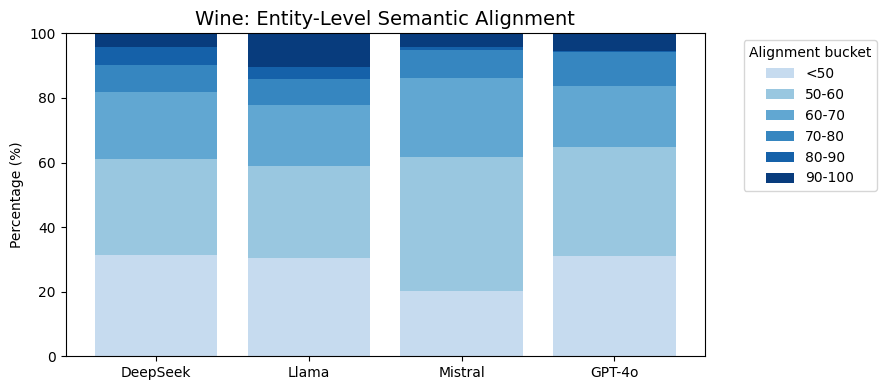

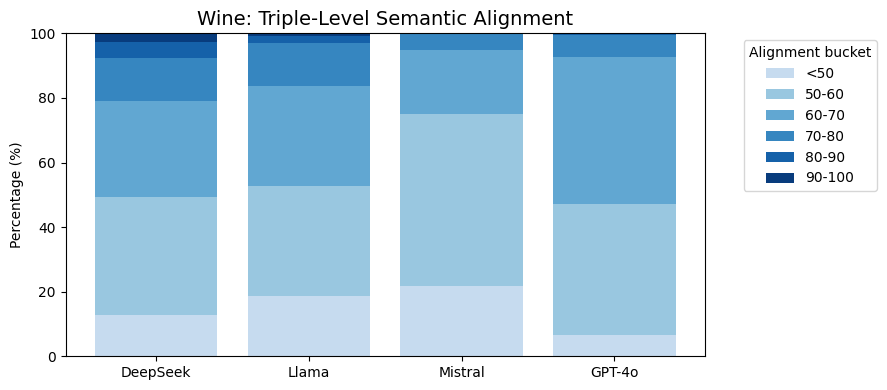

Plotting Cheminf...


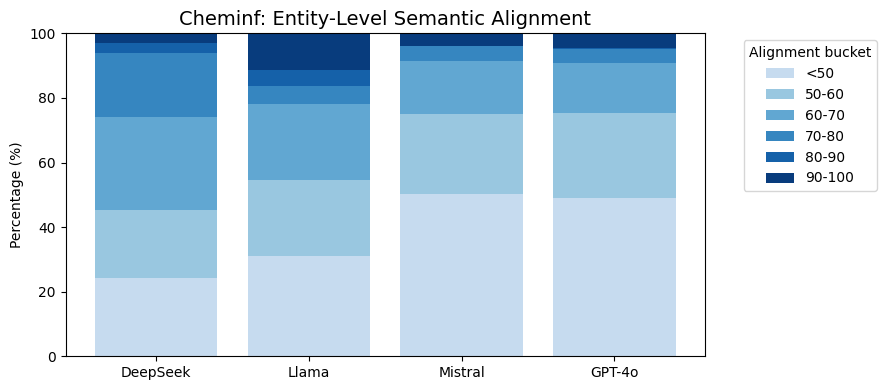

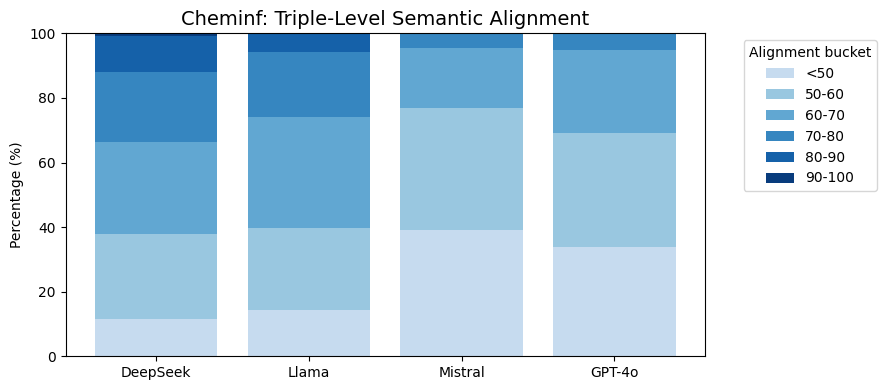

Plotting SewerNet...


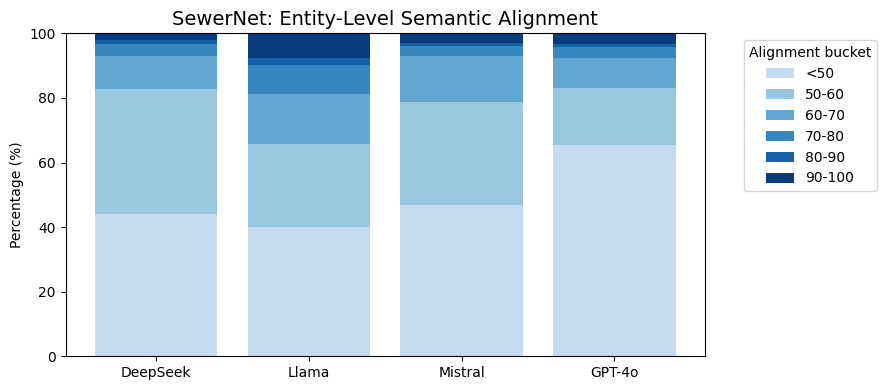

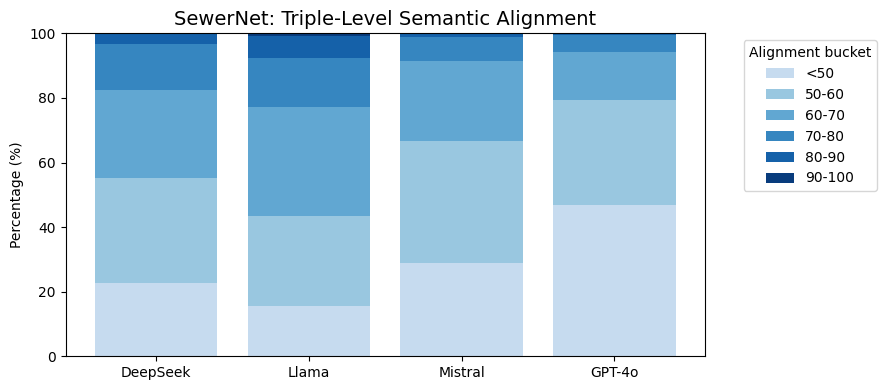

Plotting AquaDiva...


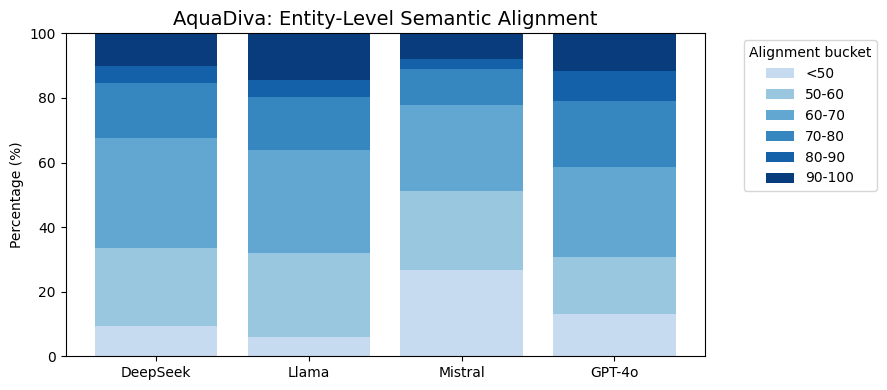

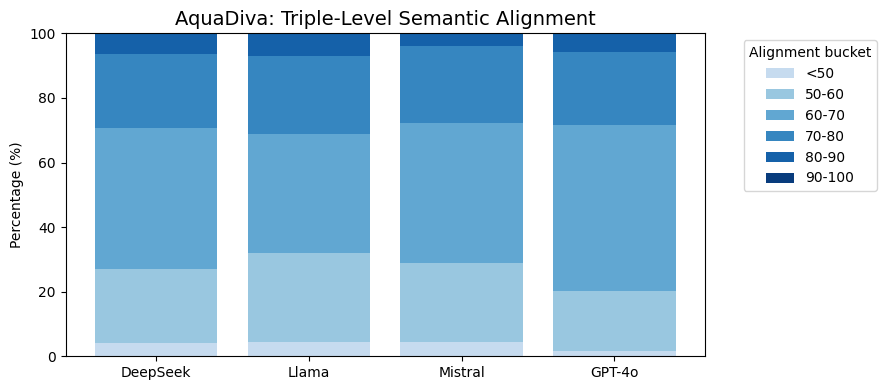

In [ ]:
for dataset_name, dataset_data in DATASETS.items():
    print(f"Plotting {dataset_name}...")

    # Entity-level
    plot_stacked_percent_bars(
        dataset_data["entities"],
        f"{dataset_name}: Entity-Level Semantic Alignment"
    )

    # Triple-level
    plot_stacked_percent_bars(
        dataset_data["triples"],
        f"{dataset_name}: Triple-Level Semantic Alignment"
    )


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

BUCKETS = ["<50", "50-60", "60-70", "70-80", "80-90", "90-100"]
x = np.arange(len(BUCKETS))

MODELS = ["DeepSeek", "Llama", "Mistral", "GPT-4o"]
COLORS = ["#1f77b4", "#ff7f0e", "#2ca02c", "#9467bd"]  # distinct colorblind-safe colors


def plot_line_chart(matrix, title):
    plt.figure(figsize=(9,4))
    for i, model in enumerate(MODELS):
        plt.plot(x, matrix[i], marker='o', linewidth=2.5, label=model, color=COLORS[i])

    plt.xticks(x, BUCKETS, fontsize=12)
    plt.ylabel("Percentage (%)", fontsize=12)
    plt.ylim(0, max(matrix.flatten()) * 1.2)
    plt.title(title, fontsize=14)
    plt.grid(axis='y', alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


Plotting Wine...


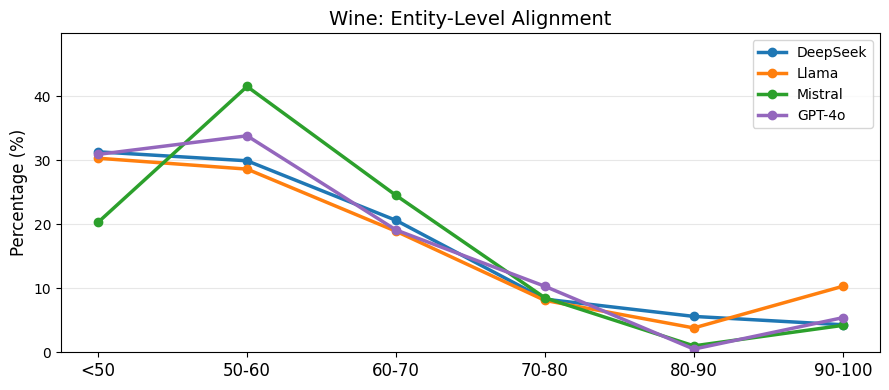

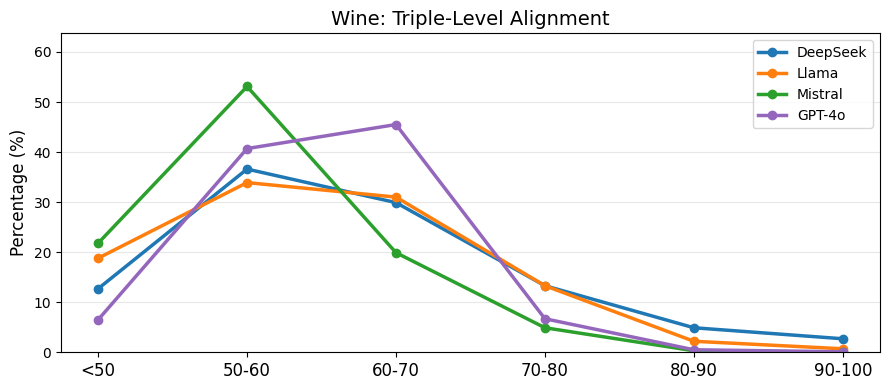

Plotting Cheminf...


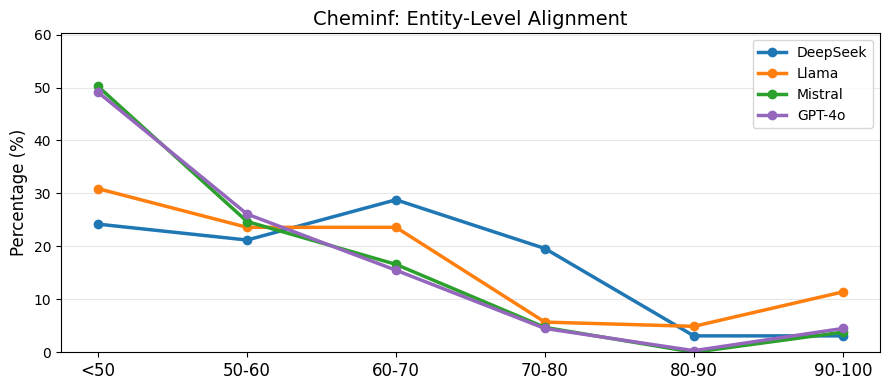

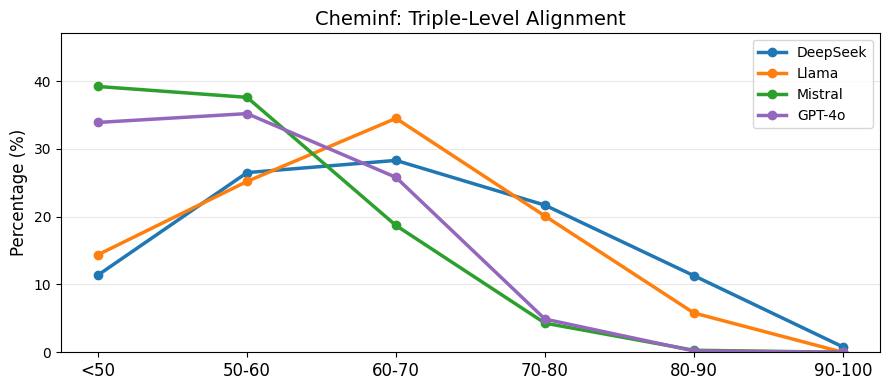

Plotting SewerNet...


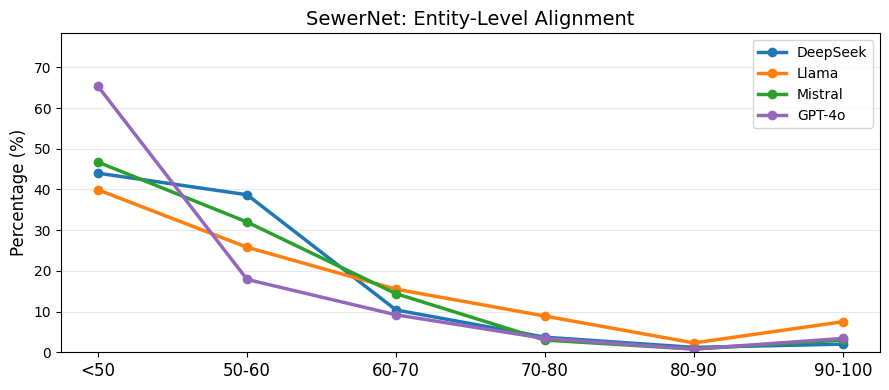

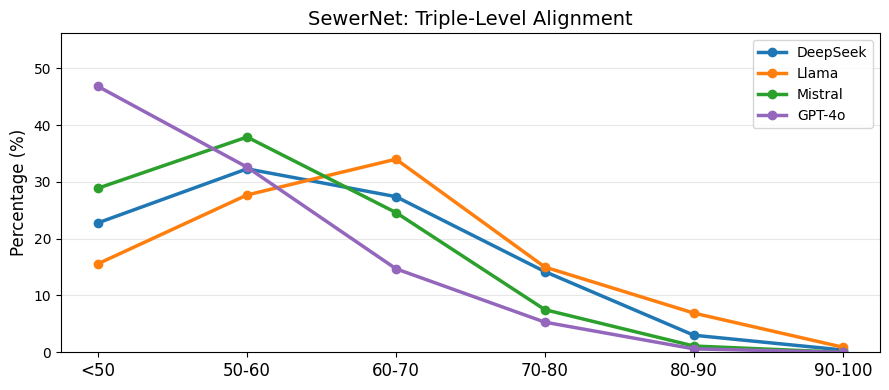

Plotting AquaDiva...


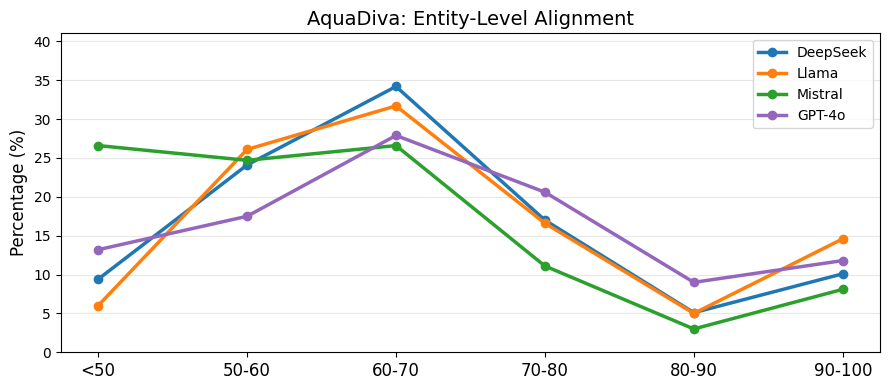

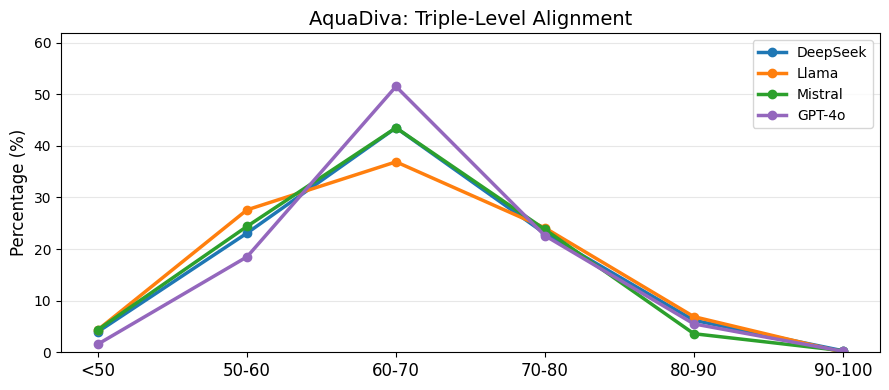

In [ ]:
for dataset_name, dataset_data in DATASETS.items():
    print(f"Plotting {dataset_name}...")
    plot_line_chart(dataset_data["entities"], f"{dataset_name}: Entity-Level Alignment")
    plot_line_chart(dataset_data["triples"],  f"{dataset_name}: Triple-Level Alignment")


In [ ]:
def plot_grouped_bars(data_matrix, title):
    """
    data_matrix shape: (num_models, num_buckets)
    Rows match the order of MODELS.
    """

    fig, ax = plt.subplots(figsize=(12, 4.5))

    num_models = len(MODELS)
    num_buckets = len(BUCKETS)
    bar_width = 0.18
    x = np.arange(num_buckets)

    bar_containers = []

    # ---- Draw bars with labels for legend ----
    for i, model in enumerate(MODELS):
        bars = ax.bar(
            x + (i - num_models/2) * bar_width + bar_width/2,
            data_matrix[i],
            width=bar_width,
            label=model,
            color=COLORS[i],
        )
        bar_containers.append(bars)

    # ---- Add percentage labels (with horizontal offsets to avoid overlap) ----
    offsets = np.linspace(-0.10, 0.10, num_models)  # small left-right shifts

    for model_idx, bars in enumerate(bar_containers):
        dx = offsets[model_idx]

        for bar in bars:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width()/2 + dx,
                height + (max(data_matrix.flatten()) * 0.015),
                f"{height:.1f}%",
                ha="center",
                va="bottom",
                fontsize=7
            )

    # ---- Axis formatting ----
    ax.set_xticks(x)
    ax.set_xticklabels(BUCKETS, fontsize=12)
    ax.set_ylabel("Percentage (%)", fontsize=13)
    ax.set_title(title, fontsize=16, pad=12)

    # Clean style like picture 2
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_linewidth(1.5)
    ax.spines["left"].set_linewidth(1.5)

    ax.grid(axis="y", alpha=0.15, linestyle="--", linewidth=0.7)

    # ---- Legend ----
    ax.legend(
        title="Model",
        title_fontsize=13,
        fontsize=12,
        frameon=True,
        facecolor="white",
        edgecolor="white",
        loc="upper left",
        bbox_to_anchor=(1.02, 1.0)
    )

    ax.set_ylim(0, max(data_matrix.flatten()) * 1.30)
    plt.tight_layout()
    plt.savefig(f"{title.replace(':','_').replace(' ','_')}.pdf",
            dpi=300,
            bbox_inches="tight")

    plt.show()


Plotting Wine...


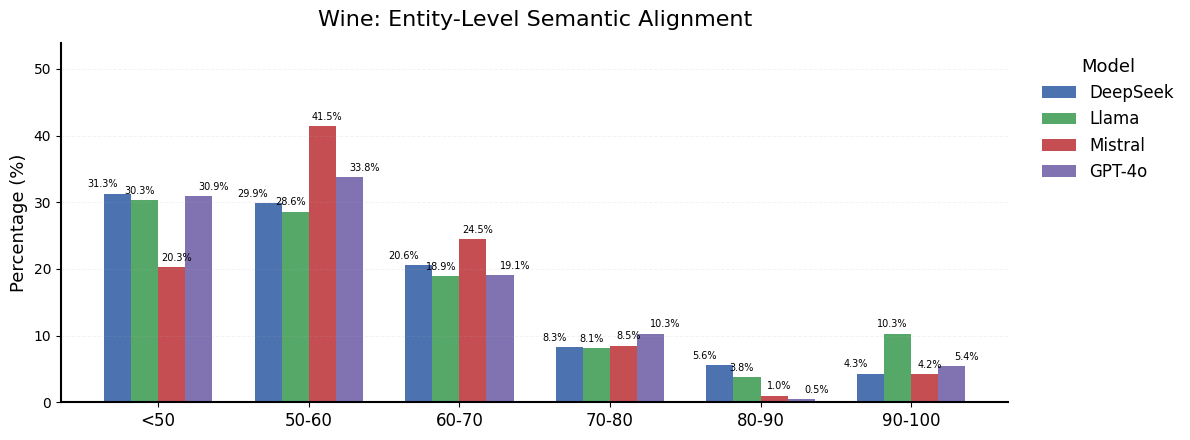

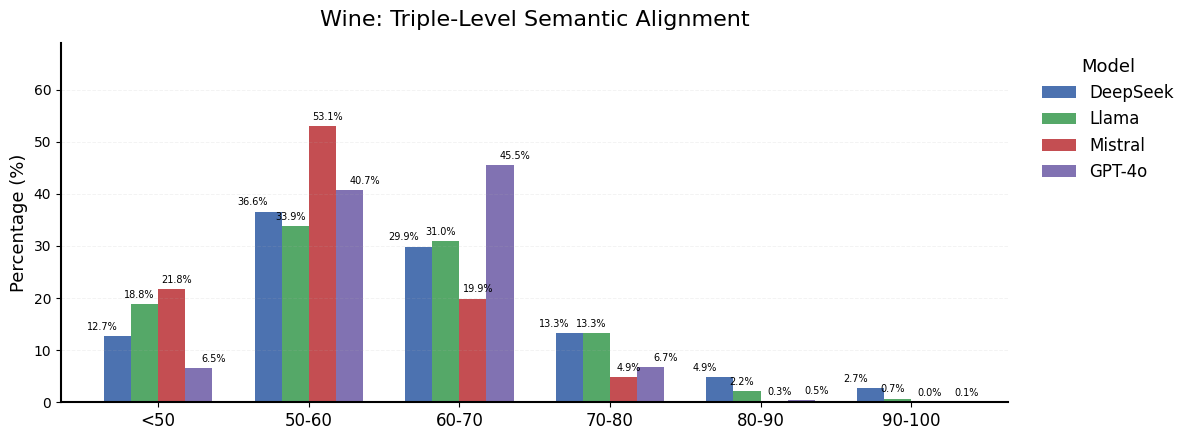

Plotting Cheminformatics...


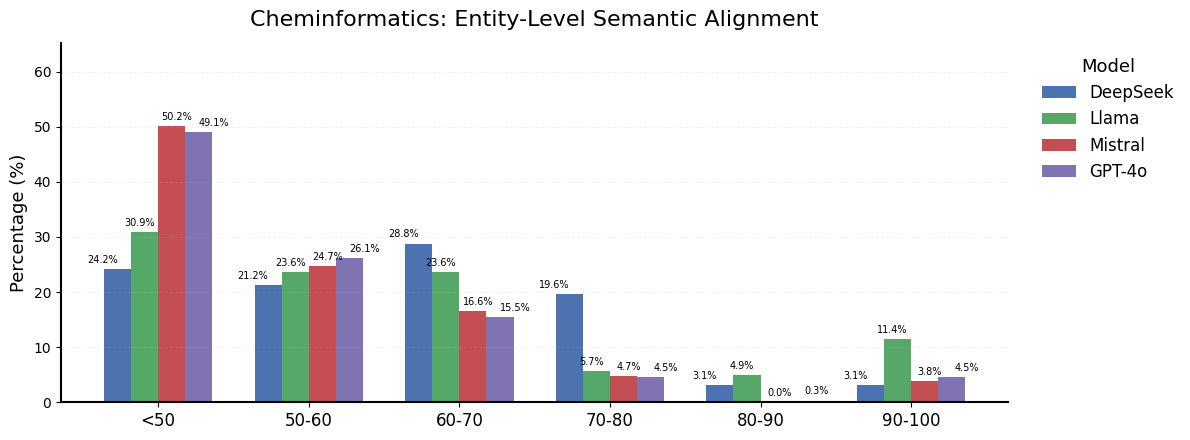

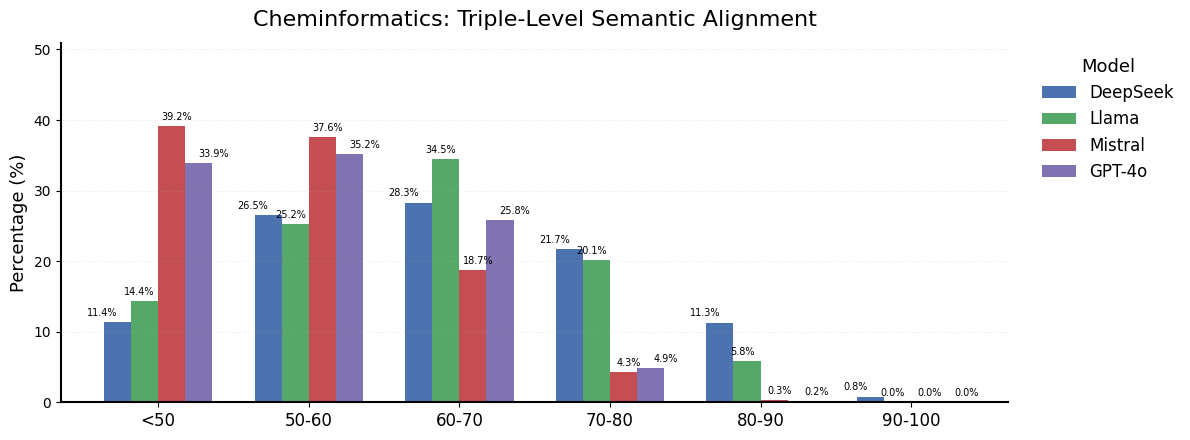

Plotting Sewer Networks...


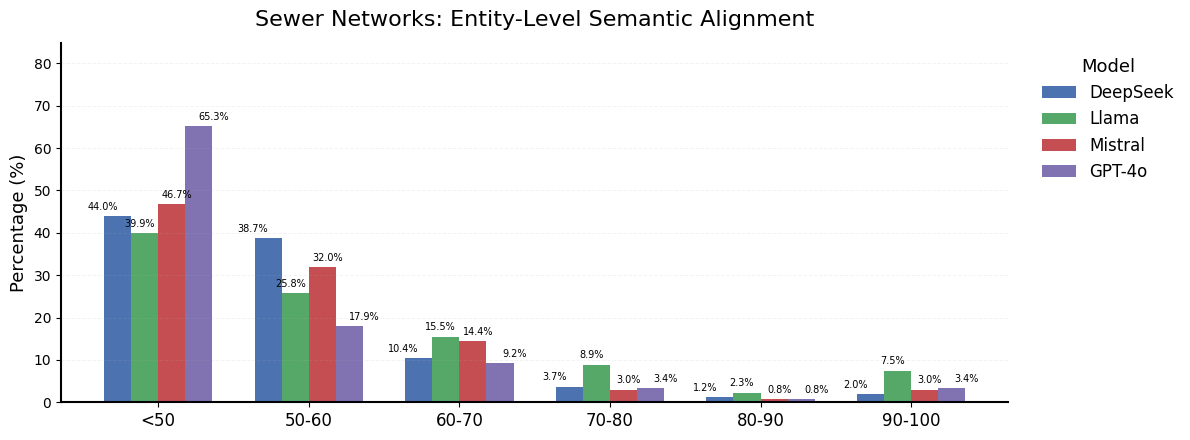

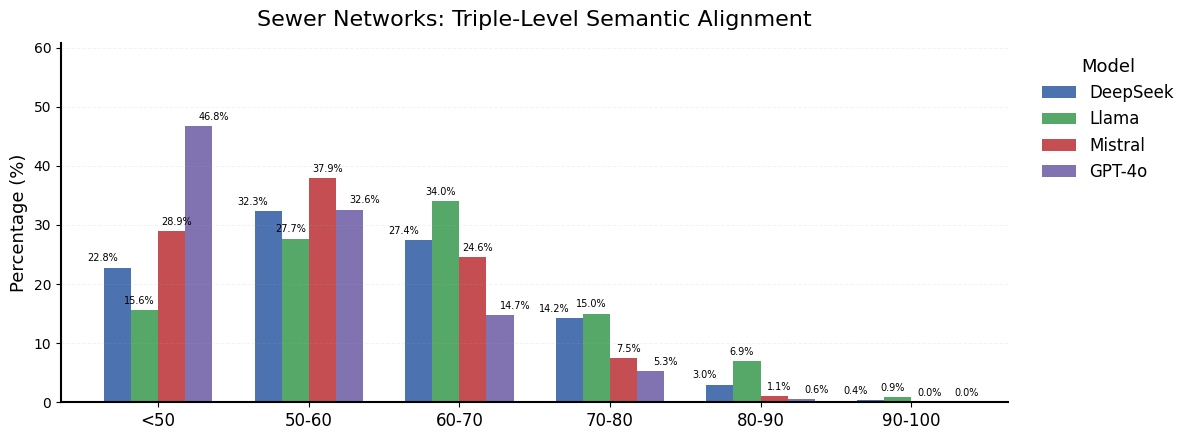

Plotting Environmental Microbiology...


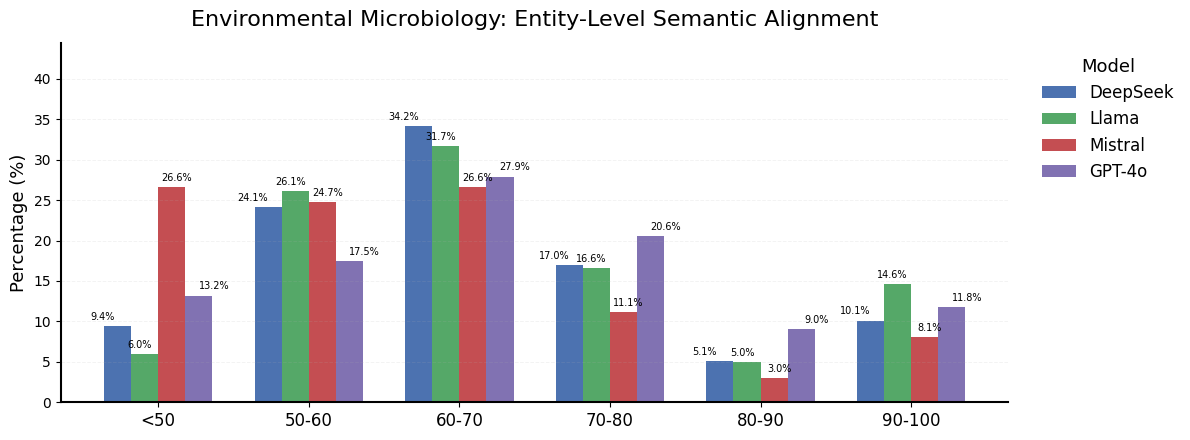

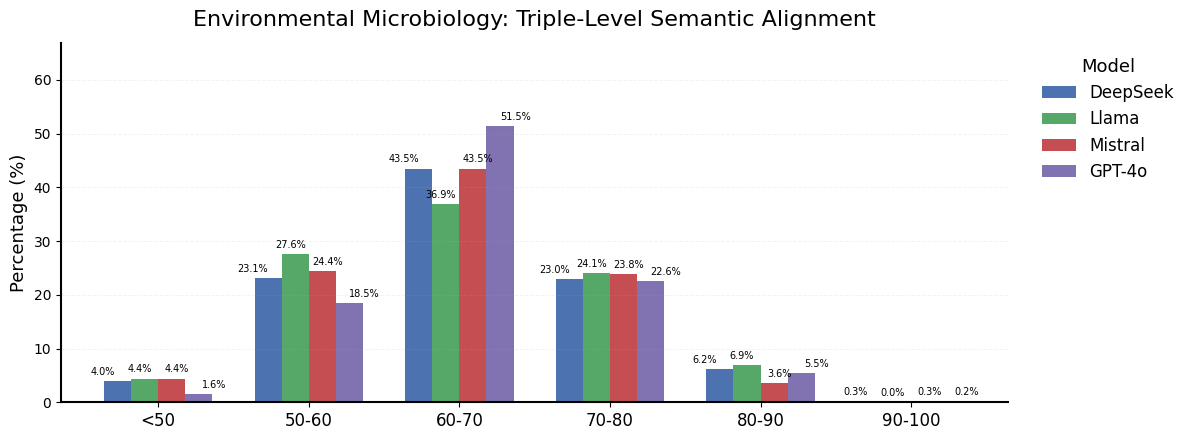

In [ ]:
for dataset_name, dataset_data in DATASETS.items():
    print(f"Plotting {dataset_name}...")

    # Entities
    plot_grouped_bars(
        dataset_data["entities"],
        f"{dataset_name}: Entity-Level Semantic Alignment"
    )

    # Triples
    plot_grouped_bars(
        dataset_data["triples"],
        f"{dataset_name}: Triple-Level Semantic Alignment"
    )
